In [1]:
%matplotlib inline
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te

In [2]:
sizes = 2**np.arange(5, 15, 2)
np_bcast_add = lambda s1, s2: timeit.Timer(setup='import numpy as np\n'
                                'import utils\n'
                                'a, b, c = utils.get_bcast_data(%s, %s)' % (s1, s2),
                                stmt='np.add(a, b, out=c)')

In [3]:
def bench_workload(workload):
    """Benchmark a workload
    workload: a method that accept a num_repeat argument
    and return its total execution time
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

In [4]:
# Defined in file: ./chapter_cpu_schedules/vector_add.md
def plot(X, Y, xlabel=None, ylabel=None, legend=[], xlim=None,
         ylim=None, xscale='linear', yscale='linear', fmts=None,
         figsize=(4.5, 3)):
    """Plot multiple lines"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    axes = plt.gca()
    X, Y = np.array(X), np.array(Y)
    if X.shape != Y.shape: X = [X] * len(Y)
    if not fmts: fmts = ['-'] * len(X)
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x, y, fmt)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend: axes.legend(legend)
    axes.grid()


# Defined in file: ./chapter_cpu_schedules/vector_add.md
def plot_gflops(sizes, gflops, legend, xlabel='Size'):
    plot(sizes, gflops, xlabel=xlabel, ylabel='GFLOPS',
             xscale='log', yscale='log',
             legend=legend, fmts=['--']*(len(gflops)-1)+['-'])

/tmp/ipykernel_15885/2816801591.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


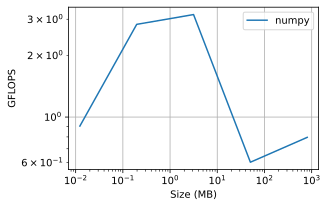

In [5]:
exe_times = [bench_workload(np_bcast_add((n, 1), (n, n)).timeit) for n in sizes]
np_gflops = sizes * sizes / 1e9 / np.array(exe_times)
# data size in MB
x_axis_sizes = (sizes * sizes * 2 + sizes * sizes) * 4 / 1e6
plot_gflops(x_axis_sizes, [np_gflops], ['numpy'], xlabel='Size (MB)')

In [6]:
import utils 

def bench_bcast_add_tvm(func, sizes, target):
    def workload(nrepeats):
        dev = tvm.device(target)
        timer = mod.time_evaluator(mod.entry_name, dev=dev, number=nrepeats)
        return timer(a, b, c).mean * nrepeats
    times = []
    for n in sizes:
        n = int(n)
        s, (A, B, C) = func(n)
        mod = tvm.build(s, [A, B, C], target)
        a, b, c = utils.get_bcast_data((n, 1), (n, n), lambda x: tvm.nd.array(x))
        times.append(bench_workload(workload))
    return sizes * sizes / 1e9 / np.array(times)

In [7]:
def broadcast_add(shape1, shape2):
    """Broadcast add between two 2-dimensional tensors
    shape1, shape2 : the shapes of the input tensors
    """
    assert len(shape1) == 2 and len(shape2) == 2, \
        "broadcast tensors should both be 2-dimension"
    for i in range(len(shape1)):
        assert shape1[i] == shape2[i] or shape1[i] == 1 or shape2[i] == 1, \
            "tensor shapes do not fit for broadcasting"
    A = te.placeholder(shape1, name='A')
    B = te.placeholder(shape2, name='B')
    m = shape1[0] if shape2[0] == 1 else shape2[0]
    n = shape1[1] if shape2[1] == 1 else shape2[1]
    f = lambda x, y: A[0 if shape1[0]==1 else x, 0 if shape1[1]==1 else y] + \
        B[0 if shape2[0]==1 else x, 0 if shape2[1]==1 else y]
    C = te.compute((m, n), f, name='C')
    return A, B, C

In [8]:
target = 'llvm -mcpu=tigerlake'
def default(n):
    A, B, C = broadcast_add((n, 1), (n, n))
    s = te.create_schedule(C.op)
    return s, (A, B, C)

def good_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].parallel(x)
    s[C].vectorize(y)
    return s, (A, B, C)

s, args = good_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (x: int32, 0, 64) "parallel" {
    let cse_var_1: int32 = (x*64)
    C[ramp(cse_var_1, 1, 64)] = (broadcast(A[x], 64) + B[ramp(cse_var_1, 1, 64)])
  }
}




/tmp/ipykernel_15885/2816801591.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


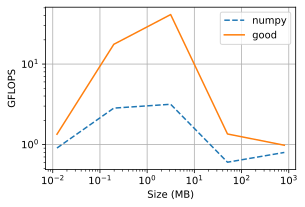

In [9]:
good_gflops = bench_bcast_add_tvm(good_schedule, sizes, target)
plot_gflops(x_axis_sizes, [np_gflops, good_gflops], ['numpy', 'good'], xlabel='Size (MB)')

In [10]:
def bad_schedule(n):
    s, (A, B, C) = default(n)
    x, y = C.op.axis
    s[C].reorder(y, x)
    s[C].parallel(y)
    s[C].vectorize(x)
    return s, (A, B, C)

s, args = bad_schedule(64)
print(tvm.lower(s, args, simple_mode=True))

@main = primfn(A_1: handle, B_1: handle, C_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {A: Buffer(A_2: Pointer(float32), float32, [64], []),
             B: Buffer(B_2: Pointer(float32), float32, [4096], []),
             C: Buffer(C_2: Pointer(float32), float32, [4096], [])}
  buffer_map = {A_1: A, B_1: B, C_1: C}
  preflattened_buffer_map = {A_1: A_3: Buffer(A_2, float32, [64, 1], []), B_1: B_3: Buffer(B_2, float32, [64, 64], []), C_1: C_3: Buffer(C_2, float32, [64, 64], [])} {
  for (y: int32, 0, 64) "parallel" {
    C[ramp(y, 64, 64)] = (A[ramp(0, 1, 64)] + B[ramp(y, 64, 64)])
  }
}




/tmp/ipykernel_15885/2816801591.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


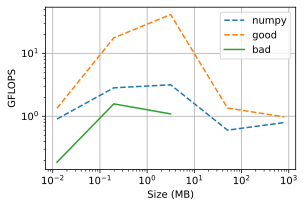

In [11]:
sizes = 2**np.arange(5, 11, 2)
bad_gflops = bench_bcast_add_tvm(bad_schedule, sizes, target)
diff = len(good_gflops)-len(bad_gflops)
bad_gflops = np.append(bad_gflops, [np.nan] * diff)
plot_gflops(x_axis_sizes, [np_gflops, good_gflops, bad_gflops],
     ['numpy', 'good', 'bad'],  xlabel='Size (MB)')